## Imports

In [3]:
import matplotlib.pyplot as plt

import shapely.geometry as geom
import shapely.affinity as aff
from shapely.ops import polygonize, unary_union

from math import sqrt

from time import sleep

## Generating self.a regular polygon

In [4]:
def makePoly(sides, radius):
    line = geom.LineString([(0, 0), (0, radius)])
    vertices = []

    if sides % 2 == 0:
        line = aff.rotate(line, -360 / sides / 2, origin=(0, 0))

    for i in range(0, sides):
        line = geom.LineString([*line.coords])
        vertices.append(line.coords[1])
        line = aff.rotate(line, -360 / sides, origin=(0, 0))

    return geom.Polygon(vertices)

## Miscellaneous and small functions

In [5]:
def extractPoint(index, poly):
    return geom.Point(poly.exterior.coords[index])

def changePoint(index, poly, direction):
    if index == 0 and direction == -1:
        return len(poly.exterior.coords) - 2
    elif index == len(poly.exterior.coords) - 2 and direction == 1:
        return 0
    else:
        return index + direction

## Plotting geometries

In [6]:
def plotCoords(coords, axes):
    x,y = zip(*list(coords))
    axes.plot(x,y)

def plotPoints(points, axes):
    x,y = zip(*list(points))
    axes.scatter(x, y)

def plotPolys(polys, axes):
    for poly in polys:
        if not getattr(poly, "exterior", None):
            print("got line?")

        plotCoords(poly.exterior.coords, axes)

        for hole in poly.interiors:
            plotCoords(hole.coords, axes)

# Big 'Ol Class

In [29]:
class Experiment:
    a = makePoly(5, 1)
    # point on self.a that might be the next rotationPoint
    nextA = [extractPoint((len(a.exterior.coords) - 2) // 2, a), (len(a.exterior.coords) - 2) // 2]
    
    def __init__(self, accuracy):
        self.accuracy = accuracy
        self.b = None
        # self.animation = animation

    def rotation(self):
        # move b so that its bottom is aligned with self.a's top
        self.b = aff.translate(self.b, yoff=abs(self.a.bounds[3]) + abs(b.bounds[1]))
        self.nextB = [extractPoint((len(self.b.exterior.coords) - 2) // 2, b), (len(self.b.exterior.coords) - 2) // 2]
        self.tracingPoint = geom.Point(self.b.centroid.coords[0][0], self.b.bounds[1])
        self.result = [*self.tracingPoint.coords]

        # setup nextA and nextB, as well as the rotation
        aAngle = (len(self.a.exterior.coords) - 3) * 180 / (len(self.a.exterior.coords) - 1)
        bAngle = (len(self.b.exterior.coords) - 3) * 180 / (len(self.b.exterior.coords) - 1)
        if (len(self.a.exterior.coords) - 1) % 2 == 1:
            # special case
            rotationAngle = (180 - aAngle) / 2
            rotationPoint = self.a.exterior.coords[0]
            self.nextA[1] = 1
        elif extractPoint(0, self.a).distance(self.b) < 0.00000000001:
            if nextB[0].__eq__(nextA[0]):
                # on edge
                rotationAngle = 360 - aAngle - bAngle
                self.nextB[1] = (self.nextB[1] - 1) % len(self.b.exterior.coords)
            else:
                # over edge
                rotationAngle = 180 - aAngle
            rotationPoint = self.a.exterior.coords[0]
            self.nextA[1] = 1
        else:
            # behind edge
            rotationAngle = 180 - bAngle
            rotationPoint = (nextB[0].x, nextB[0].y)
            self.nextA[1] = 0

        self.animRotate(rotationAngle, rotationPoint)
        # rotate until result is complex (intersects itself)
        # i = 0
        # while geom.LineString(self.result).is_simple or i < 2:
        for i in range(0, 5):
            if self.nextA[0].distance(b) < 0.00000000001:
                if self.nextB[0].__eq__(self.nextA[0]):
                    # on edge
                    rotationAngle = 360 - aAngle - bAngle
                    self.nextB[1] = changePoint(self.nextB[1], self.b, -1)
                else:
                    # over edge
                    rotationAngle = 180 - aAngle
                rotationPoint = (self.nextA[0].x, self.nextA[0].y)
                self.nextA[1] = changePoint(self.nextA[1], self.a, 1)
            else:
                # behind edge
                bAngle = (len(self.b.exterior.coords) - 3) * 180 / (len(self.b.exterior.coords) - 1)
                rotationAngle = 180 - bAngle
                rotationPoint = (self.nextB[0].x, self.nextB[0].y)
                self.nextB[1] = changePoint(self.nextB[1], self.b, -1)
            self.animRotate(rotationAngle, rotationPoint)
            i =+ 1

        fig, ax = plt.subplots()
        ax.axes.set_aspect("equal")
        ax.plot(self.result)

        # result = geom.LineString(self.result)
        # result = polygonize(unary_union(result)) # split result into polygons that don't intersect each other

        # copy = result[0]
        # for index, val in enumerate(result, 1):
        #     # if val's diagonal is larger than copy's, i.e. val contains copy
        #     if sqrt((val.bounds[2] - val.bounds[0])**2 + (val.bounds[3] - val.bounds[1])**2) > sqrt((copy.bounds[2] - copy.bounds[0])**2 + (copy.bounds[3] - copy.bounds[1])**2):
        #         copy = val
        # self.result = copy

    def animRotate(self, rotationAngle, rotationPoint):
        if self.accuracy > rotationAngle:
            iterations = -1
            angleLeftOver = rotationAngle
        else:
            iterations = int(rotationAngle // self.accuracy)
            angleLeftOver = rotationAngle - self.accuracy * iterations

        b, accuracy, tracingPoint, result = self.b, self.accuracy, self.tracingPoint, self.result
        # rotationAngle is negative for clockwise, accuracy is the number of degrees between recording position
        for i in range(iterations):
            b = aff.rotate(b, -accuracy, origin=rotationPoint)
            tracingPoint = aff.rotate(tracingPoint, -accuracy, origin=rotationPoint)
            result.append(*tracingPoint.coords)

        b = aff.rotate(b, -angleLeftOver, origin=rotationPoint)
        tracingPoint = aff.rotate(tracingPoint, -angleLeftOver, origin=rotationPoint)
        if angleLeftOver > 0:
            result.append(*tracingPoint.coords)

        self.b, self.accuracy, self.tracingPoint, self.result = b, accuracy, tracingPoint, result
        self.nextA[0] = extractPoint(self.nextA[1], self.a)
        self.nextB[0] = extractPoint(self.nextB[1], self.b)

Testing = Experiment(1)

# Animation

NameError: name 'rotation' is not defined

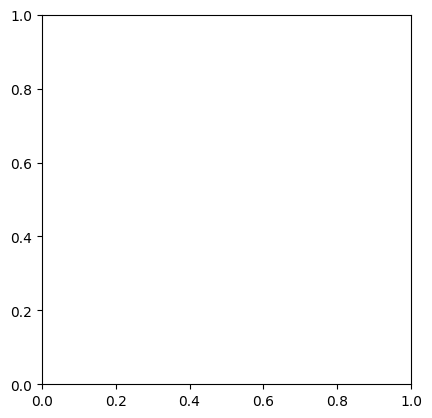

In [8]:
fig, ax = plt.subplots()
ax.axes.set_aspect("equal")

b = makePoly(3, 2)
result = rotation(b, 3, animation=True)

# Testing

## Graphs

In [ ]:
x_data = [[], [], []]
y_data = [[], [], []]
i = 0.1
while i <= 4:
    # try:
    #     result = rotation(makePoly(3, i), 1)
    #     x_data[0].append(result[0])
    #     y_data[0].append(result[1])
    # except IndexError:
    #     print(0, i)

    try:
        Testing.b = makePoly(5, i)
        Testing.rotation()
        x_data[1].append(Testing.b.length)
        y_data[1].append(Testing.result.length)
    except IndexError:
        print(1, i)

    # try:
    #     result = rotation(makePoly(8, i), 1)
    #     x_data[2].append(result[0])
    #     y_data[2].append(result[1])
    # except IndexError:
    #     print(2, i)
    i += 0.1

1
2
3


KeyboardInterrupt: 

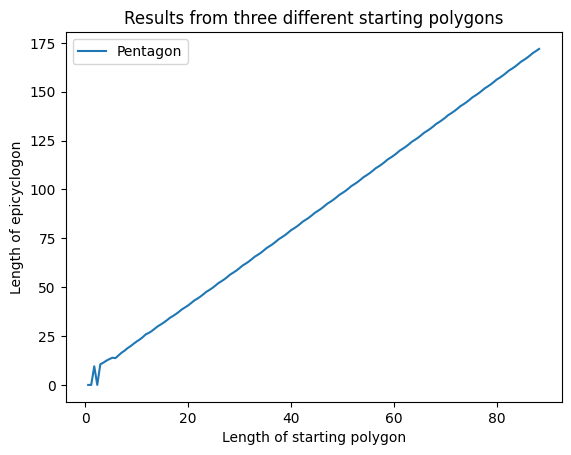

In [ ]:
fig, ax = plt.subplots()
ax.set(title="Results from three different starting polygons", ylabel="Length of epicyclogon", xlabel="Length of starting polygon")
# ax.plot(x_data[0], y_data[0], label="Triangle")
ax.plot(x_data[1], y_data[1], label="Pentagon")
# ax.plot(x_data[2], y_data[2], label="Octogon")
ax.legend()

## Visualising an individual epicyclogon

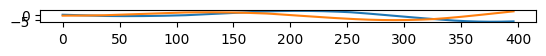

In [32]:
# fig, ax = plt.subplots()
# ax.axes.set_aspect("equal")

Testing.b = makePoly(4, 4)
Testing.rotation()

# plotPolys([Testing.a, Testing.b, Testing.result], ax)

# Pictures

## Result

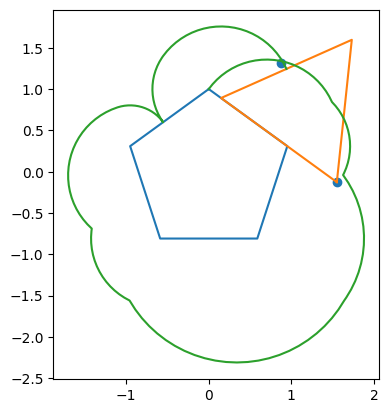 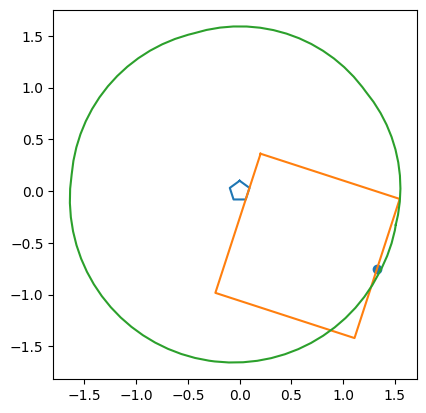 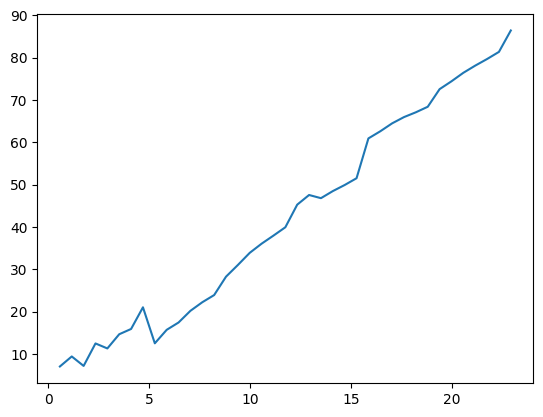

## States after rotation

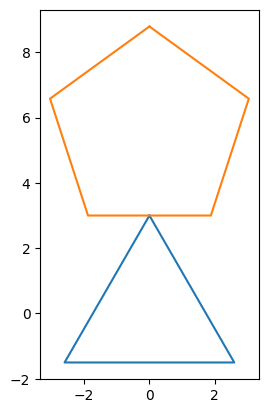 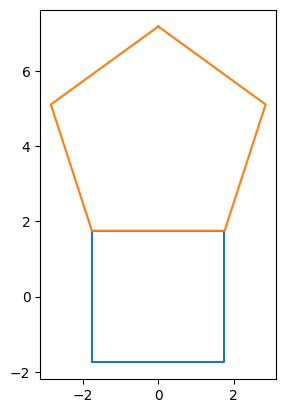 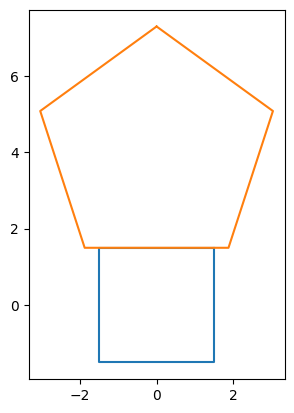 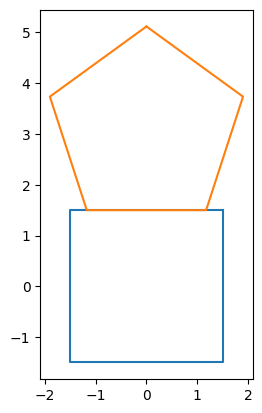